### Data Rundown

#### train.csv
store_nbr: store identifier  
family: type of product sold  
sales: total sales for a family at a store on a date  
onpromotion: number of items in that family on sale  

#### test.csv
test data. To predict target sales. For 15 days after train.csv ends


#### stores.csv
store metadata. contains city, state, type and cluster. Cluster is a grouping of similar stores


#### oil.csv
Daily oil price, for dates in test and train timeframe.


#### holidays_events.csv
Holiday dates. Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer.


### Further Notes:
Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
holidays_events = pd.read_csv('holidays_events.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
oil_df = pd.read_csv('oil.csv')
sample_df = pd.read_csv('sample_submission.csv')
stores_df = pd.read_csv('stores.csv')
transactions_df = pd.read_csv('transactions.csv')

oil_df['date'] = pd.to_datetime(oil_df['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

## remove transfer days
holidays_events = holidays_events.drop(holidays_events[holidays_events['transferred'] == True].index)

## POINT FOR FURTHER EXPLORATION
''' for simplicity, we drop holidays that arent national. Local holidays will no doubt see a boost in local sales. But this might require a series of local models, or a cleverly put together model that examines each region'''


In [57]:
train_df[0:40]

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [55]:
holidays_events['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

## Plan, Step 1
There are many variables to explore, given we are forcasting for a future date, we explore time first. We have 4 years worth of data and 54 unique stores. This is too much, so we group the stores based on the info in stores_df and then plot the sales over time.

In [50]:
selected_stores_df = stores_df[['store_nbr', 'cluster']]

train_df_withclusters = pd.merge(train_df, selected_stores_df, on='store_nbr', how='left')

summed_df = train_df_withclusters.groupby(['cluster', 'date']).sum().reset_index()

In [51]:
summed_df['date'] = pd.to_datetime(summed_df['date'])


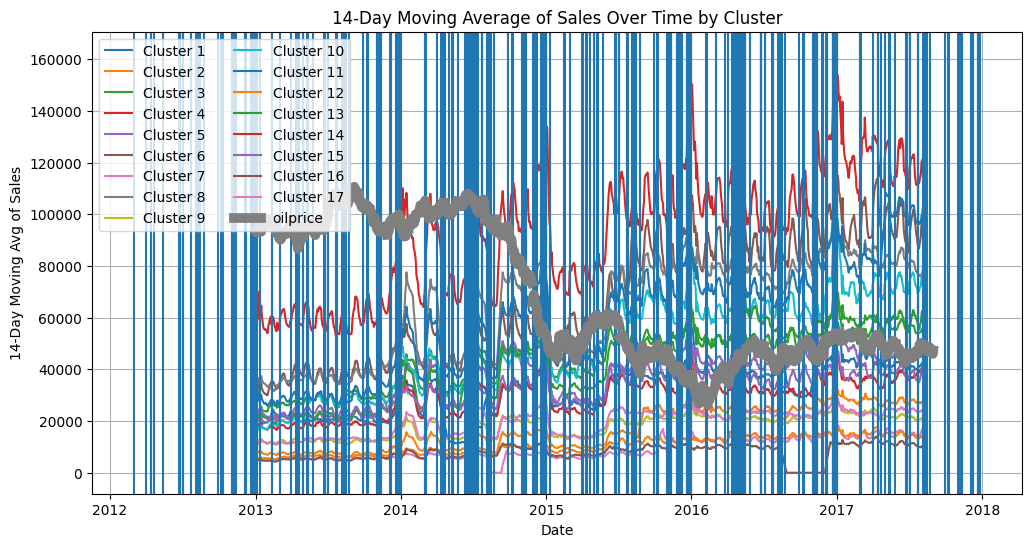

In [52]:
summed_df['sales_rolling_14d'] = (
    summed_df.groupby('cluster')['sales']
    .transform(lambda x: x.rolling(window=14, min_periods=1).mean())
)

plt.figure(figsize=(12, 6))
for cluster, group in summed_df.groupby('cluster'):
    plt.plot(group['date'], group['sales_rolling_14d'], label=f'Cluster {cluster}')

for date in holidays_events['date']:
    plt.axvline(x=date)

plt.plot(oil_df['date'],oil_df['dcoilwtico']*1000,linewidth=7.0,label='oilprice')

plt.xlabel('Date')
plt.ylabel('14-Day Moving Avg of Sales')
plt.title('14-Day Moving Average of Sales Over Time by Cluster')
plt.legend(loc='upper left', ncol=2)
plt.grid(True)

plt.show()


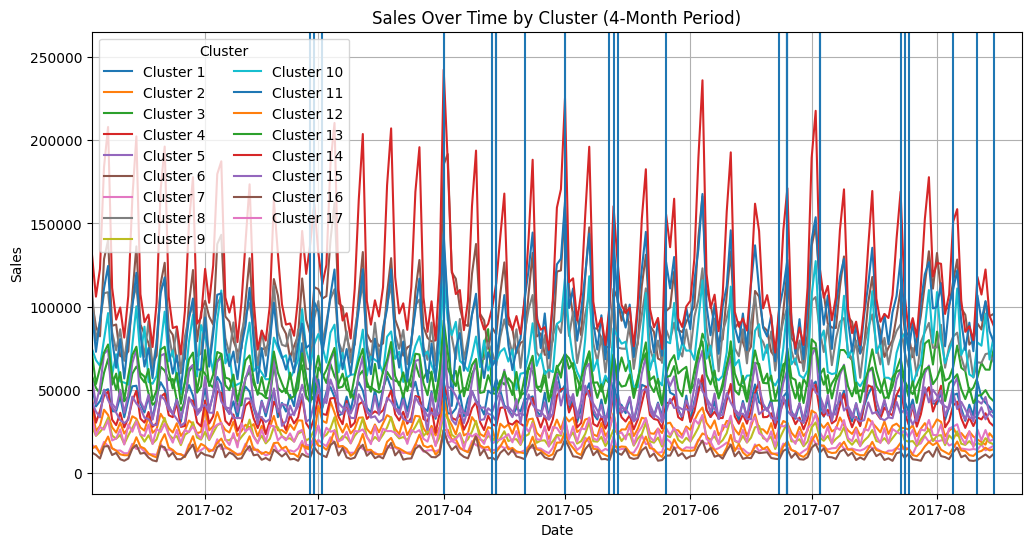

In [53]:
# Filter for a specific 4-month period
filtered_df = summed_df[(summed_df['date'] >= '2017-01-01') & (summed_df['date'] <= '2017-08-30')]

# Plot sales for the filtered time period
plt.figure(figsize=(12, 6))
for cluster, group in filtered_df.groupby('cluster'):
    plt.plot(group['date'], group['sales'], label=f'Cluster {cluster}')

for date in holidays_events['date']:
    plt.axvline(x=date)

plt.xlim((17170,17400))

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time by Cluster (4-Month Period)')
plt.legend(title='Cluster', loc='upper left', ncol=2)
plt.grid(True)

# Show the plot
plt.show()


## Model 1

There is a clear temporal pattern to the sales data. To make use of this, we implement an LSTM model. To then make use of the traditional features and numerical data by implementing a forest ensemble method - which tend to cope well with non linear relationships.

## Plan, Step 2

So we will develop an LSTM model and combine it with a forest model. Now we will inspect and form the training data for the forest model. We want to add a number of features, for whether that day was a holiday, what the oil prices were, and perhaps location or transactions data.  

One important aspect is how we deal with the dimensionality of the data, particularly in the way of stores and dates. We want to predict sales for each store on each date for a future 2 week period.  

We could have 1 model per store, and combine that with the LSTMs, for now, and for simplicity, we will develop a single model. To cope with the stores dimension, we could encode the stores into a feature, but to hopefully improve model performance, we will use store embeddings to capture relationships between similar stores.

In [59]:
stores_df

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15
